# Random Forest

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from IPython.display import SVG

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

RDKit WARNING: [11:12:39] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
import json
with open('../../course_config.json') as json_file:
    CONFIG = json.load(json_file)

In [3]:
import os, sys
sys.path.append(os.path.abspath(CONFIG['utilities_path']))
from feature_importance_utils import moltosvg

### Intro to Dataset

Today, we'll take a look in the chromofore compounds dataset, provided by the authors of the paper [*Experimental database of optical properties of organic compounds, 2020*](https://www.nature.com/articles/s41597-020-00634-8)

In [4]:
opt_df = pd.read_csv(CONFIG['dataset_path']+'DB for chromophore_Sci_Data_rev02.csv', index_col=0)
opt_df.tail()

,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
Tag,,,,,,,,,,,,,
20232,N#Cc1c(N2CCCC2)cc(-c2ccccc2)c2c1C(=O)c1ccccc1-2,C1CCOC1,358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.41992,DOI: 10.1021/ol9000679
20233,N#Cc1c(N2CCCCC2)cc(-c2ccccc2)c2c1C(=O)c1ccccc1-2,C1CCOC1,348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364.44680,DOI: 10.1021/ol9000679
20234,N#Cc1c(N2CCCCC2)cc(-c2cccc3ccccc23)c2c1C(=O)c1...,C1CCOC1,344.0,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,414.50668,DOI: 10.1021/ol9000679
20235,N#Cc1c(N2CCCCC2)cc(-c2ccc3ccccc3c2)c2c1C(=O)c1...,C1CCOC1,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,414.50668,DOI: 10.1021/ol9000679
20236,N#Cc1c(N2CCCCC2)cc(-c2ccc3ccc4cccc5ccc2c3c45)c...,C1CCOC1,344.0,473.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488.58856,DOI: 10.1021/ol9000679


In this dataset we can analyze Chromophore-Solvent pairs and their properties. We'll be using Absorption max (nm) feature as target during our regression studies.
<br>We'll start with finding most popular chromophores:

In [5]:
opt_df['Chromophore'].value_counts()[:5]

[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3ccccc3)cc2-c2ccccc2)cc1-c1ccccc1    335
COC(=O)C(Cc1ccc2oc(-c3ccc(Nc4ccccc4)cc3)nc2c1)NC(=O)OC(C)(C)C                     36
COC(=O)C(Cc1ccc2oc(-c3ccc4c(c3)c3ccccc3n4-c3ccccc3)nc2c1)NC(=O)OC(C)(C)C          36
COC(=O)C(Cc1ccc2oc(-c3ccc(N(C)C)cc3)nc2c1)NC(=O)OC(C)(C)C                         36
COC(=O)C(Cc1ccc2oc(-c3ccc(N(C)c4ccccc4)cc3)nc2c1)NC(=O)OC(C)(C)C                  35
Name: Chromophore, dtype: int64

It seems that 2,6-Diphenyl-4-(2,4,6-triphenylpyridinio)phenolate *(yep, I google it...)* is the most described chromophore. We'll attempt to predict the target value depending on the properties of solvents. Formula of our chromofore is shown below:

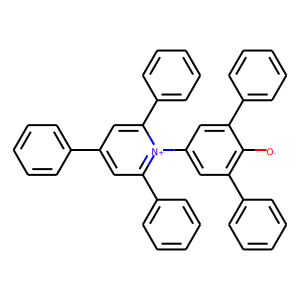

In [6]:
m = opt_df['Chromophore'].value_counts().keys()[0]
SVG(moltosvg(Chem.MolFromSmiles(m)))

In [7]:
chrom_df = opt_df[opt_df['Chromophore'] == m]
chrom_df.describe()

,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1)
count,335.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.350000e+02
mean,695.760112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02
std,111.420637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.138569e-13
min,437.840735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02
25%,603.828657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02
50%,699.046455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02
75%,774.823848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02
max,1055.018450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.516873e+02


As most of the properties are NaN, we'll build molecular descriptors for all solvents

In [8]:
chrom_df = chrom_df[['Solvent', 'Absorption max (nm)']][1:].reset_index(drop=True)

In [9]:
def init_mol_dictionary():
    mol_dict = {}
    mol_dict['C'], mol_dict['N'], mol_dict['O'], mol_dict['X'] = 0,0,0,0   
    mol_dict['Cinring'], mol_dict['Ninring'], mol_dict['Oinring'], mol_dict['Xinring'] = 0,0,0,0
    mol_dict['C1N'], mol_dict['C2N'], mol_dict['CarN'], mol_dict['C3N'] = 0,0,0,0
    mol_dict['C1O'], mol_dict['C2O'], mol_dict['CarO'] = 0,0,0
    mol_dict['N1O'], mol_dict['N2O'] = 0,0
    mol_dict['C1C'], mol_dict['C2C'], mol_dict['CarC'], mol_dict['C3C'] = 0,0,0,0
    mol_dict['N1N'], mol_dict['N2N'], mol_dict['NarN'], mol_dict['N3N'] = 0,0,0,0
    mol_dict['O1O'] = 0
    return mol_dict

In [10]:
bond_order_dict={
    Chem.BondType.SINGLE: '1',
    Chem.BondType.DOUBLE: '2',
    Chem.BondType.TRIPLE: '3',
    Chem.BondType.AROMATIC: 'ar',
}
atom_priority_order = {
    "C": 1,
    "N": 2,
    "O": 3
}

In [11]:
def get_mol_data(mol):
    m_dict = init_mol_dictionary()
    for i in range(mol.GetNumAtoms()):
        atom = mol.GetAtomWithIdx(i)
        if atom.GetSymbol() in m_dict: 
            m_dict[atom.GetSymbol()] += 1
            m_dict[atom.GetSymbol()+'inring'] += 1 if atom.IsInRing() else 0
            for neighbor in atom.GetNeighbors():
                if neighbor.GetIdx() > i and neighbor.GetSymbol() in m_dict:
                    if atom_priority_order[atom.GetSymbol()] < atom_priority_order[neighbor.GetSymbol()]:
                        atom1, atom2 = atom.GetSymbol(), neighbor.GetSymbol()
                    else:
                        atom2, atom1 = atom.GetSymbol(), neighbor.GetSymbol()
                    key = '{atom1}{bond_order}{atom2}'.format(atom1=atom1, atom2 = atom2,
                            bond_order = bond_order_dict[mol.GetBondBetweenAtoms(i,neighbor.GetIdx()).GetBondType()])
                    m_dict[key] +=1
        else:
            m_dict['X'] += 1
            m_dict['Xinring'] += 1 if atom.IsInRing() else 0
    return m_dict

In [12]:
df_dict = {}
for i, solv in enumerate(chrom_df['Solvent']):
    df_dict[i] = get_mol_data(Chem.MolFromSmiles(solv))

In [13]:
chrom_df = pd.concat([chrom_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = chrom_df['Absorption max (nm)']
X = chrom_df.drop(['Solvent', 'Absorption max (nm)'], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Comparing single tree, bagging and random forest for regression

In [15]:
# Single decision tree regressor
dtree = DecisionTreeRegressor(random_state = 42).fit(X_train, y_train)
d_predict = dtree.predict(X_test)
print('Single decision tree regressor mse: {}'.format(mean_squared_error(y_test, d_predict)))

# Bagging
bdt = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, 
                       random_state=42).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)
print('Bagging mse: {}'.format(mean_squared_error(y_test, bdt_predict)))

# Random Forest
rf = RandomForestRegressor(n_estimators=10, random_state = 42).fit(X_train, y_train)
rf_predict = rf.predict(X_test)
print('Random Forest mse: {}'.format(mean_squared_error(y_test, rf_predict)))

Single decision tree regressor mse: 3858.2188989608862
Bagging mse: 2671.4984421004206
Random Forest mse: 2766.001130621972


As one can see from the mse values, a random forest of 10 trees achieves much better result than a single decision tree and is quite comparable to bagging with the same number of trees. The main difference between random forests and bagging is in selecting features to split on:
- in random forests, the best feature for a split is selected from a random subset of available features
- in bagging all features are considered for the next best split.

Todo: pic showing difference

### Random Forest Regression

The description of all RandomForestRegressor properties is given on the [sklearn website](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
<br>Among most important are (v.0.24.0):
- `n_estimators` default=100 - the number of trees in the forest.
- `criterion` default=”mse” - function to measure the quality of a split: “mse”, “mae”
- `max_depth` default=None - the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- `min_samples_split` default=2 - the minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
- `min_samples_leaf` default=1 - the minimum number of samples required to be at a leaf node. If int, then consider min_samples_leaf as the minimum number. If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
- `min_weight_fraction_leaf` default=0.0 - the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- `max_features` default=”auto” - the number of features to consider when looking for the best split:
    <br>- if int, then consider max_features features at each split.
    <br>- if float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
    <br>- if “auto”, then max_features=n_features.
    <br>- if “sqrt”, then max_features=sqrt(n_features).
    <br>- if “log2”, then max_features=log2(n_features).
    <br>- if None, then max_features=n_features.
    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
- `warm_startbool` default=False - when set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest. 
- `max_samples` default=None - if bootstrap is True, the number of samples to draw from X to train each base estimator.
    <br>- if None (default), then draw X.shape[0] samples.
    <br>- if int, then draw max_samples samples.
    <br>- if float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0, 1).


We'll vary `RandomForestRegressor` parameters with a `GridSearchCV`. This will automate our search on several folds. Of all features we'll look for best values of `max_depth` and `n_estimators`:

In [16]:
def rfr_model(X, y):
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(random_state = 42),
        param_grid={
            'max_depth': range(3,12),
            'n_estimators': (10, 25, 50, 75, 100),
            'max_features': ['auto', 'sqrt', 'log2'],
            'oob_score': [True, False] 
        },
        cv=10, scoring='neg_mean_squared_error', verbose=0,n_jobs=-1)
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], 
                                random_state=42, verbose=False)
    scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_error')
    return rfr, best_params, -np.mean(scores)

In [17]:
model, params, scores = rfr_model(X_train, y_train)
print(params, scores)

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 75, 'oob_score': True} 3460.623610272739


In [18]:
rf_predict = model.fit(X_train, y_train).predict(X_test)
mean_squared_error(y_test, rf_predict)

3018.9580850422212

### Comparing single tree, bagging and random forest for classification

For classification purposes we'll use the same dataset, but a bit differently. We've studied how solvent purposes influence the Absorption max (nm) property. Suppose, all other solvents don't form proper conditions with our chromophore. Let's see if we can build a suitable/unsuitable solvent classifier.
<br>First, let's count the number of solvents we have and the number of suitable ones:

In [19]:
len(opt_df['Solvent'].unique()), len(chrom_df['Solvent'].unique())

(1336, 334)

In [20]:
cl_df = pd.DataFrame()
cl_df['Solvent'] = opt_df[opt_df['Solvent'] != 'gas']['Solvent'].unique()
cl_df['target'] = 0 
cl_df.loc[cl_df['Solvent'].isin(list(chrom_df['Solvent'].unique())), 'target'] = 1
cl_df['target'].value_counts()

0    1001
1     334
Name: target, dtype: int64

In [21]:
df_dict = {}
for i, solv in enumerate(cl_df['Solvent']):
    df_dict[i] = get_mol_data(Chem.MolFromSmiles(solv))

In [22]:
cl_df = pd.concat([cl_df, pd.DataFrame.from_dict(df_dict, orient='index')], axis=1)
y = cl_df['target']
X = cl_df.drop(['Solvent', 'target'], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [24]:
dtree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
d_predict = dtree.predict(X_test)
print('Single decision tree classifier accuracy: {}'.format(accuracy_score(y_test, d_predict)))

bdt = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, random_state=42).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)
print('Bagging classifier accuracy: {}'.format(accuracy_score(y_test, bdt_predict)))

rf = RandomForestClassifier(n_estimators=10, random_state=42).fit(X_train, y_train)
rf_predict = bdt.predict(X_test)
print('Random forest classifier accuracy: {}'.format(accuracy_score(y_test, rf_predict)))

Single decision tree classifier accuracy: 0.963718820861678
Bagging classifier accuracy: 0.9750566893424036
Random forest classifier accuracy: 0.9750566893424036


### Random Forest Classification

params

In [25]:
def rfc_model(X, y):
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(random_state = 42),
        param_grid={
            'max_depth': range(3,12),
            'n_estimators': (10, 25, 50, 75, 100),
            'max_features': ['auto', 'sqrt', 'log2']
        },
        cv=10, scoring='accuracy', verbose=0,n_jobs=-1)
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    rfc = RandomForestClassifier(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], 
                                random_state=42, verbose=False)
    scores = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')
    return rfc, best_params, np.mean(scores)

In [26]:
model, params, scores = rfc_model(X_train, y_train)
print(params, scores)

{'max_depth': 7, 'max_features': 'auto', 'n_estimators': 10} 0.9832025610445043


In [27]:
rf_predict = model.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, rf_predict)

0.981859410430839

In [28]:
# Initialize a stratified split of our dataset for the validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=75, max_depth=8, max_features='log2', random_state=42, n_jobs=-1, 
                                 min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best CV accuracy is 98.43% with 1 min_samples_leaf


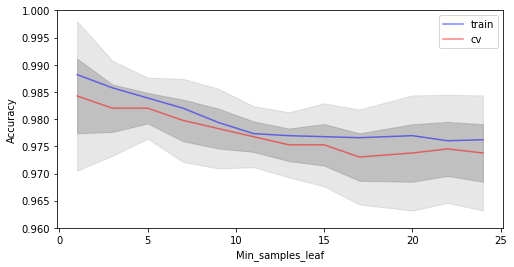

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), 
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), 
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.96,1.0])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");
plt.show()

In [30]:
#todo: comapre individual tree and bagging
#todo: classifier
#todo morgan fingerprints

In [31]:
opt_df['Solvent'].value_counts()[:5]

ClCCl        2562
CC#N         2004
Cc1ccccc1    1580
C1CCOC1      1437
ClC(Cl)Cl    1312
Name: Solvent, dtype: int64

In [32]:
len(list(opt_df['Solvent'].unique()))

1336

A major disadvantage of random forests lies in their complexity. They required much more computational resources, owing to the large number of decision trees joined together.
Due to their complexity, they require much more time to train than other comparable algorithms.


# Appendix

## Extremely Randomized Trees¶

Extremely Randomized Trees employ a greater degree of randomization at the cut-point choice when splitting a tree node. As in random forests, a random subset of features is used. But, instead of the search for the optimal thresholds, their values are selected at random for each possible feature, and the best one among these randomly generated thresholds is used as the best rule to split the node. This usually trades off a slight reduction in the model variance with a small increase of the bias.

In the scikit-learn library, there are 2 implementations of Extremely Randomized Trees: [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) and [ExtraTreesRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor).

This method should be used if you have greatly overfit with random forests or gradient boosting.